# Visualize an Abstract Syntax Tree

https://github.com/hchasestevens/show_ast

In [1]:
import ast
import graphviz
import itertools
from functools import partial
from IPython.display import SVG

_basestring = basestring

def recurse_through_ast(node, handle_ast, handle_terminal, handle_fields, handle_no_fields, omit_docstrings):
    possible_docstring = isinstance(node, (ast.FunctionDef, ast.ClassDef, ast.Module))
    
    node_fields = zip(
        node._fields,
        (getattr(node, attr) for attr in node._fields)
    )
    field_results = []
    for field_name, field_value in node_fields:
        if isinstance(field_value, ast.AST):
            field_results.append(handle_ast(field_value))
        
        elif isinstance(field_value, list):
            if possible_docstring and omit_docstrings and field_name == 'body':
                field_value = _strip_docstring(field_value)
            field_results.extend(
                handle_ast(item)
                if isinstance(item, ast.AST) else
                handle_terminal(item)
                for item in field_value
            )
        
        elif isinstance(field_value, _basestring):
            field_results.append(handle_terminal('"{}"'.format(field_value)))
            
        elif field_value is not None:
            field_results.append(handle_terminal(field_value))

    if not field_results:
        return handle_no_fields(node)

    return handle_fields(node, field_results)

my_settings = dict(
    # Styling options:
    scale=2,
    font='courier',
    shape='none',
    terminal_color='#008040',
    nonterminal_color='#004080',
    # AST display options:
    omit_module=True,
    omit_docstrings=True,
)

def _strip_docstring(body):
    first = body[0]
    if isinstance(first, ast.Expr) and isinstance(first.value, ast.Str):
        return body[1:]
    return body

def _bold(label):
    return '<<B>{}</B>>'.format(label)


def _attach_to_parent(parent, graph, names, label, name=None, **style):
    node_name = next(names) if name is None else name
    node = graph.node(node_name, label=label, **style)
    if parent is not None:
        graph.edge(parent, node_name, sametail='t{}'.format(parent))


def handle_ast(node, parent_node, graph, names, omit_docstrings, terminal_color, nonterminal_color):
    attach_to_parent = partial(
        _attach_to_parent,
        graph=graph,
        names=names,
    )
    node_name = next(names)
    attach_to_parent(
        parent=parent_node,
        label=_bold(node.__class__.__name__),
        name=node_name,
        fontcolor=nonterminal_color,
    )
    recurse_through_ast(
        node, 
        partial(
            handle_ast, 
            parent_node=node_name,
            graph=graph,
            names=names,
            omit_docstrings=omit_docstrings, 
            terminal_color=terminal_color, 
            nonterminal_color=nonterminal_color,
        ), 
        partial(
            handle_terminal, 
            attach_to_parent=partial(
                attach_to_parent, 
                parent=node_name, 
                fontcolor=terminal_color,
            ),
        ), 
        handle_fields, 
        partial(
            handle_no_fields,
            parent_node=node_name,
            graph=graph,
            terminal_color=terminal_color,
            nonterminal_color=nonterminal_color,
        ),
        omit_docstrings,
    )


def handle_terminal(terminal, attach_to_parent):
    attach_to_parent(label=str(terminal))


def handle_fields(*__):
    pass


def handle_no_fields(__, parent_node, graph, terminal_color, nonterminal_color):
    parent_node_beginning = '{} '.format(parent_node)
    parent_node_num = int(parent_node)
    for i, node in enumerate(graph.body[parent_node_num:]):
        if node.strip().startswith(parent_node_beginning):
            break
    else:
        raise KeyError("Could not find parent in graph.")
    replacements = {
        nonterminal_color: terminal_color,
        '<<B>': '',
        '</B>>': '',
    }
    graph.body[i + parent_node_num] = reduce(
        lambda s, replacement: s.replace(*replacement),
        replacements.items(),
        node,
    )
    
def render(node, settings):
    """
    Given an AST node and settings, return a displayable object.
    """
    graph = graphviz.Graph(format='svg')
    names = (str(x) for x in itertools.count())

    handle_ast(
        node,
        parent_node=None,
        graph=graph,
        names=names,
        omit_docstrings=settings['omit_docstrings'],
        terminal_color=settings['terminal_color'],
        nonterminal_color=settings['nonterminal_color'],
    )

    graph.node_attr.update(dict(
        fontname=settings['font'],
        shape=settings['shape'],
    ))

    return SVG(graph.pipe(format='svg'))

def viz_code(code):
    return render(ast.parse(code), my_settings)

In [2]:
hi_code = '''
def hello():
    """Return Hi."""
    return 'Hi!'
'''

In [3]:
_strip_docstring(ast.dump(ast.parse(hi_code)))

"Module(body=[FunctionDef(name='hello', args=arguments(args=[], vararg=None, kwarg=None, defaults=[]), body=[Expr(value=Str(s='Return Hi.')), Return(value=Str(s='Hi!'))], decorator_list=[])])"

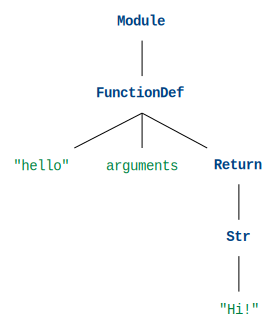

In [4]:
viz_code(hi_code)

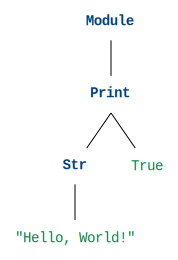

In [5]:
viz_code('''print "Hello, World!"''')

In [6]:
hello_code = '''def say_hello():
    print("Hello, World!")

say_hello()'''

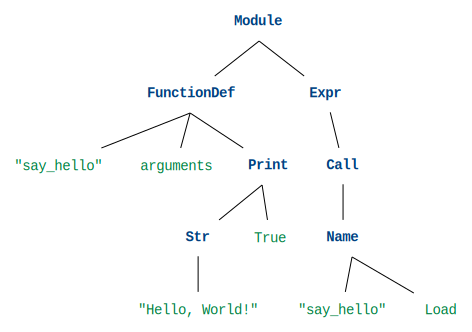

In [7]:
viz_code(hello_code)

In [8]:
sum_code = '''
#!/usr/bin/env python
# read from input
a = int(raw_input()) # first
b = int(raw_input()) # second
print a + b
'''

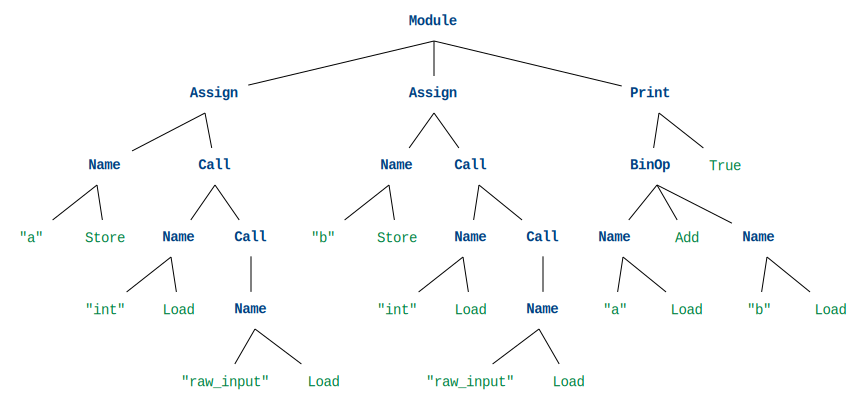

In [9]:
viz_code(sum_code)

In [10]:
divisors_code = '''def divisors(n):
    for d in range(1, n + 1):
        if n % d == 0:
            print d'''

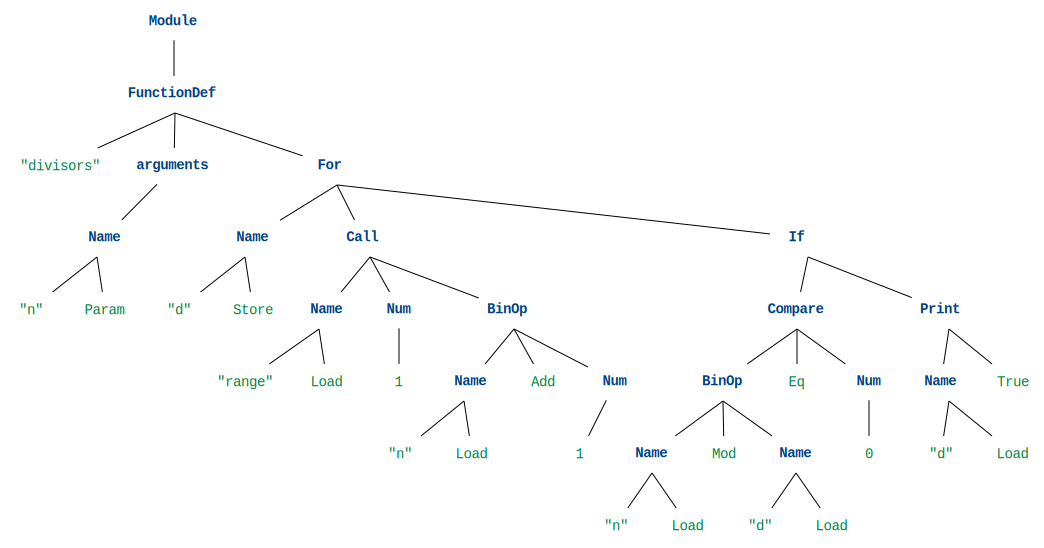

In [11]:
viz_code(divisors_code)

In [12]:
program_score = '''
n = input()
i = 0
away_score = (away_goals * 3) + away_points
home_score = (home_goals * 3) + home_points 
while n < 4:
    n = input()
    if home_score > away_score :
        print "home win"
    elif home_score < away_score :
        print "away win"
    else:
        print "draw"
    i = i + 1
'''

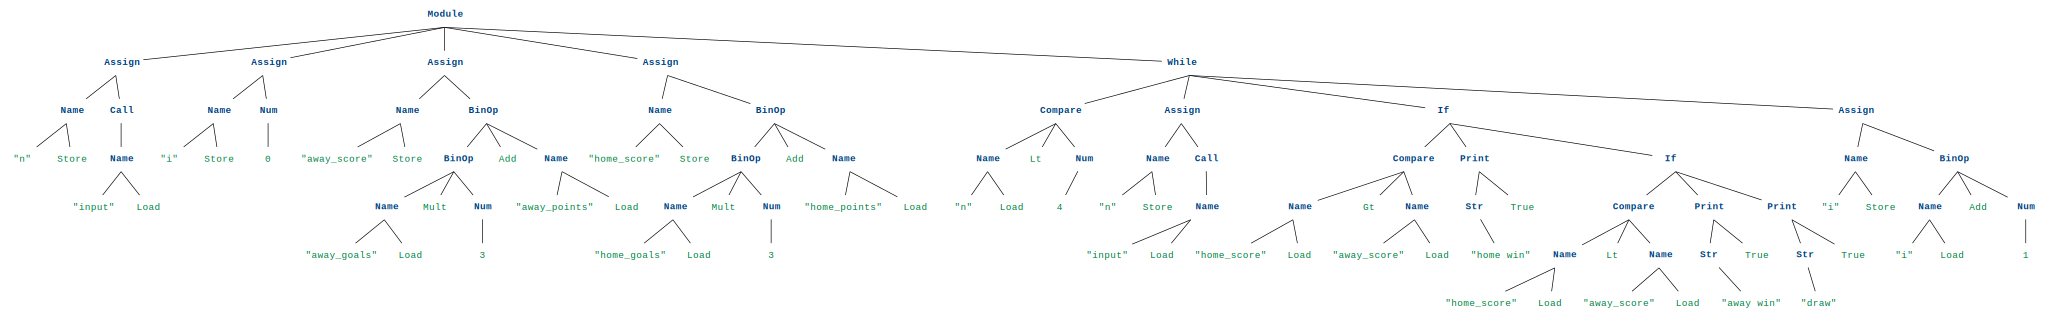

In [13]:
viz_code(program_score)